In [1]:
import numpy as np 
import pandas as pd
import openturns as ot
import otkerneldesign as otkd
import matplotlib.pyplot as plt

## Uncertainty propagation methods

See the following API page for regarding the methods used below: 

https://openturns.github.io/openturns/latest/user_manual/designs_of_experiments.html

https://efekhari27.github.io/otkerneldesign/master/user_manual/_generated/otkerneldesign.KernelHerding.html

In [2]:
def generate_MC(distribution, size):
    x_sample = distribution.getSample(size)
    return np.array(x_sample)

def generate_QMC(distribution, size):
    # Other sequences are available (Halton, Faure, etc.)
    # Pass the last argument as True for randomized QMC 
    qmc_experiment = ot.LowDiscrepancyExperiment(ot.SobolSequence(), distribution, size, False) 
    x_sample = qmc_experiment.generate()
    return np.array(x_sample)

def generate_LHS(distribution, size):
    lhs_experiment = ot.LHSExperiment(distribution, size)
    x_sample = lhs_experiment.generate()
    return np.array(x_sample)

def generate_KH(distribution, size):
    # Support points rely on a specific 
    sp = otkd.GreedySupportPoints(
            distribution=distribution,
            candidate_set_size=2 ** 12, # increase if the dimension higher 
            )
    x_sample = sp.select_design(size)
    return np.array(x_sample)

## Uniform inputs

In [3]:
dim = 2
uniform_distribution = ot.ComposedDistribution([ot.Uniform(0., 1.)] * dim)

In [4]:
size = 128
# Monte Carlo
x_MC_sample = generate_MC(uniform_distribution, size)
# Quasi-Monte Carlo 
x_QMC_sample = generate_QMC(uniform_distribution, size)
# LHS
x_LHS_sample = generate_LHS(uniform_distribution, size)
# Kernel herding 
x_KH_sample = generate_KH(uniform_distribution, size)

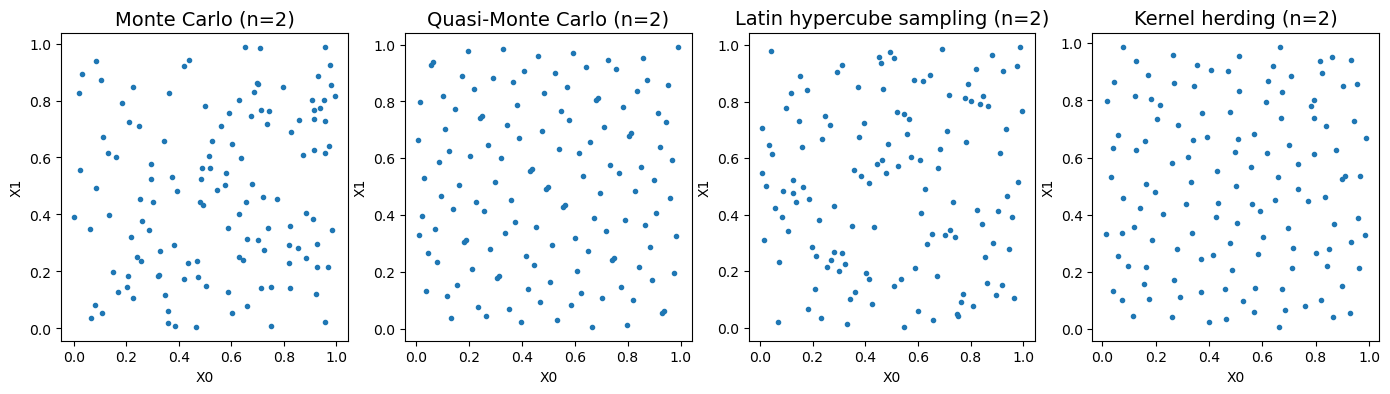

In [5]:
titles_labels = ['Monte Carlo', 'Quasi-Monte Carlo', 'Latin hypercube sampling', 'Kernel herding']
samples_list = [x_MC_sample, x_QMC_sample, x_LHS_sample, x_KH_sample]
fig, axs = plt.subplots(1, 4, figsize=(17, 4))
for i in range(4):
    x_sample = samples_list[i]
    axs[i].scatter(x_sample[:, 0], x_sample[:, 1], marker='.')
    axs[i].set_xlabel('X0')
    axs[i].set_ylabel('X1')
    axs[i].set_title(f'{titles_labels[i]} (n={x_sample.shape[1]})', fontsize=14)

### Non-uniform inputs

See the large catalogue of marginals and copulas available in OpenTURNS: 

http://openturns.github.io/openturns/latest/user_manual/probabilistic_modelling.html

In [6]:
weibull = ot.WeibullMin(2.0, 1.5, 1.0)
exponential = ot.Exponential(1.) 
marginals = [weibull, exponential]
# Copulas 
correlation = ot.CorrelationMatrix(2)
correlation[1, 0] = 0.8 # introduce correlation coefficients
normal_copula = ot.NormalCopula(correlation)
# Many other copula models available
clayton_copula = ot.ClaytonCopula(2.5)
# Distributions 
#my_distribution = ot.ComposedDistribution(marginals, clayton_copula)
my_distribution = ot.ComposedDistribution(marginals)

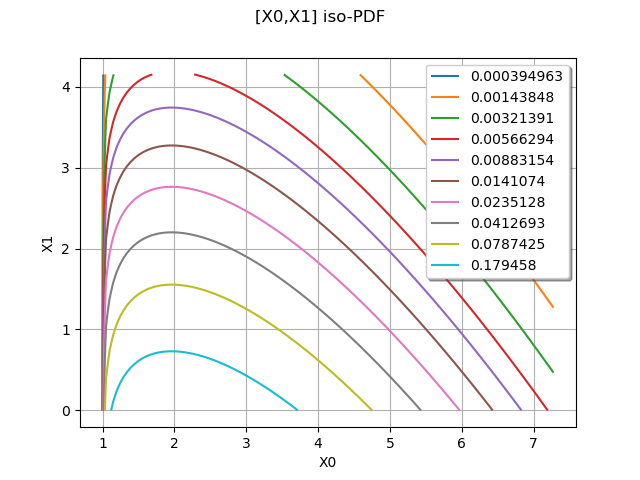

In [7]:
# 2D joint distributions plotting
graph = my_distribution.drawPDF()
graph.setColors(ot.Drawable.BuildDefaultPalette(10))
graph

In [8]:
size = 256
# Monte Carlo
x_MC_sample = generate_MC(my_distribution, size)
# Quasi-Monte Carlo 
x_QMC_sample = generate_QMC(my_distribution, size)
# LHS
# Note that the LHSExperiment class only accept independent distributions to keep the LHS structure
x_LHS_sample = generate_LHS(my_distribution, size)
# Kernel herding 
x_KH_sample = generate_KH(my_distribution, size)

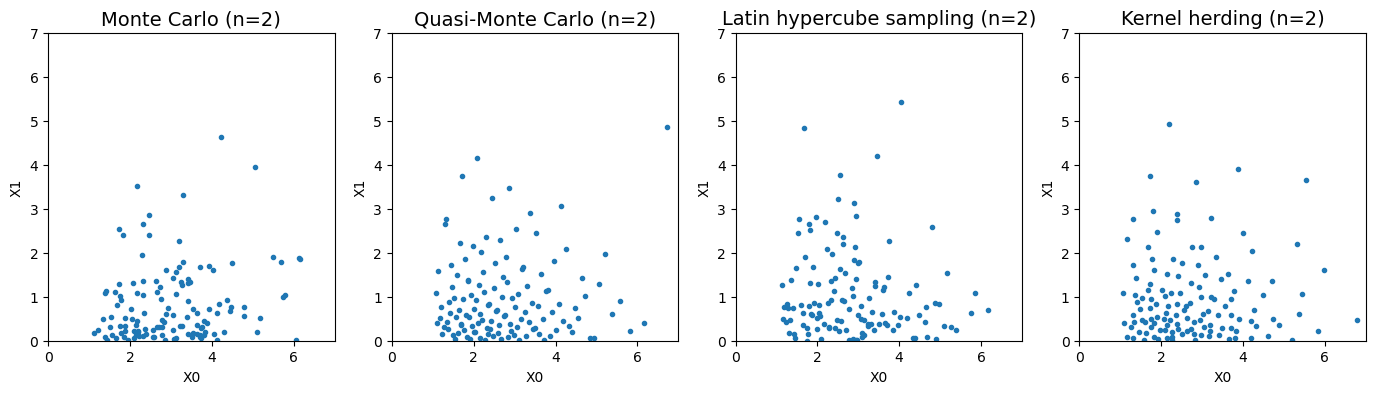

In [9]:
plotted_size = 128
samples_list = [x_MC_sample[:plotted_size, :], x_QMC_sample[:plotted_size, :], x_LHS_sample[:plotted_size, :], x_KH_sample[:plotted_size, :]]
fig, axs = plt.subplots(1, 4, figsize=(17, 4))
for i in range(4):
    x_sample = samples_list[i]
    axs[i].scatter(x_sample[:, 0], x_sample[:, 1], marker='.')
    axs[i].set_xlabel('X0')
    axs[i].set_ylabel('X1')
    axs[i].set_title(f'{titles_labels[i]} (n={x_sample.shape[1]})', fontsize=14)
    axs[i].set_xlim(0, 7)
    axs[i].set_ylim(0, 7)

## Mean estimation

Function in OpenTURNS can be defined either using `ot.SymbolicFunction` when the function is explicit, otherwise it can be done using `ot.PythonFunction`

In [10]:
my_function = ot.SymbolicFunction(['x1', 'x2'], ['x1^2 + 3*x2'])

### Monte Carlo reference 

In [11]:
ref_size = int(1e6)
x_MC_reference = my_distribution.getSample(ref_size)
y_MC_reference = my_function(x_MC_reference)
mc_ref = np.mean(y_MC_reference)
print(f'Monte Carlo mean reference: {mc_ref}')

Monte Carlo mean reference: 12.366161223129236


### Mean convergence benchmark

In [12]:
x_indexes = np.arange(1, size + 1)
# Evaluate designs
y_MC_sample = my_function(x_MC_sample)
y_QMC_sample = my_function(x_QMC_sample)
y_LHS_sample = my_function(x_LHS_sample)
y_KH_sample = my_function(x_KH_sample)
# Estimate means
y_MC_means = np.cumsum(y_MC_sample) / x_indexes
y_QMC_means = np.cumsum(y_QMC_sample) / x_indexes
y_LHS_means = np.cumsum(y_LHS_sample) / x_indexes
y_KH_means = np.cumsum(y_KH_sample) / x_indexes 

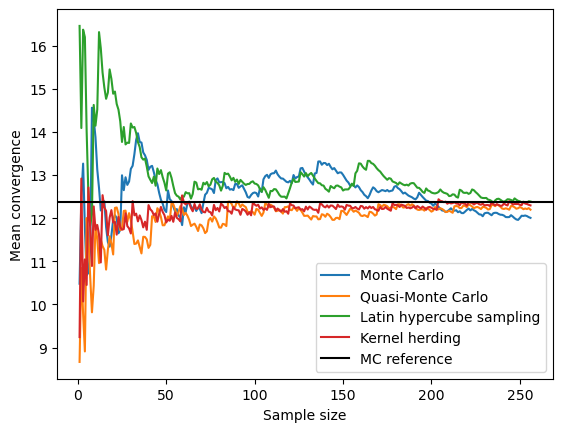

In [13]:
titles_labels = ['Monte Carlo', 'Quasi-Monte Carlo', 'Latin hypercube sampling', 'Kernel herding']
mean_convergence_list = [y_MC_means, y_QMC_means, y_LHS_means, y_KH_means]
fig = plt.figure()
for i, mean_convergence in enumerate(mean_convergence_list): 
    plt.plot(x_indexes, mean_convergence, color=f'C{i}', label=titles_labels[i])
plt.axhline(mc_ref, color='k', label="MC reference")
plt.xlabel('Sample size')
plt.ylabel('Mean convergence')
plt.legend(loc='lower right');